In [1]:
%matplotlib inline

import math
import warnings
import numpy as np

# specify to ignore warning messages
warnings.filterwarnings("ignore") 

import keras
from lstm_utils import get_raw_data
from lstm_utils import get_reg_model
from lstm_utils import plot_reg_results
from lstm_utils import get_reg_train_test
from lstm_utils import predict_reg_multiple

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Set Parameters

In [3]:
WINDOW = 6
PRED_LENGTH = int(WINDOW/2)
STOCK_INDEX = '^GSPC'

## Getting Data

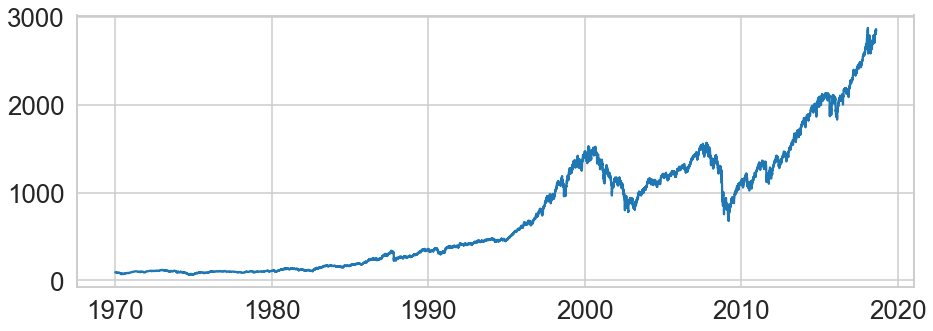

In [4]:
import datetime

start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2018, 8, 12)

sp_df = get_raw_data(STOCK_INDEX, start, end)
sp_close_series = sp_df.Close 

sp_close_series.plot()

## Preprocessing Data

In [5]:
x_train,y_train,x_test,y_test,scaler = get_reg_train_test(sp_close_series,
                                                      sequence_length=WINDOW+1,
                                                      roll_mean_window=None,
                                                      normalize=True,
                                                      scale=False)
    
print("Data Split Complete")

print("x_train shape={}".format(x_train.shape))
print("y_train shape={}".format(y_train.shape))
print("x_test shape={}".format(x_test.shape))
print("y_test shape={}".format(y_test.shape))

Data Split Complete
x_train shape=(15971, 6, 1)
y_train shape=(15971,)
x_test shape=(1775, 6, 1)
y_test shape=(1775,)


## Prepare LSTM Model

In [6]:
lstm_model=None
try:
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)   
except:
    print("Model Build Failed. Trying Again")
    lstm_model = get_reg_model(layer_units=[50,100],
                           window_size=WINDOW)

> Compilation Time :  0.02000141143798828
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
______________________________

## Fit the Model

In [7]:
# use eatrly stopping to avoid overfitting     
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
lstm_model.fit(x_train, y_train, 
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Train on 15172 samples, validate on 799 samples
Epoch 1/20
15172/15172 [==============================] - 10s 630us/step - loss: 1.4363e-04 - val_loss: 1.3054e-04
Epoch 2/20
15172/15172 [==============================] - 8s 551us/step - loss: 1.0018e-04 - val_loss: 1.6804e-04
Epoch 3/20
15172/15172 [==============================] - 8s 551us/step - loss: 9.7976e-05 - val_loss: 8.5038e-05
Epoch 4/20
15172/15172 [==============================] - 8s 547us/step - loss: 9.4078e-05 - val_loss: 9.1452e-05
Epoch 5/20
15172/15172 [==============================] - 8s 549us/step - loss: 9.3095e-05 - val_loss: 9.5280e-05
Model Fit Complete


## Train Prediction Performance

In [8]:
train_pred_seqs = predict_reg_multiple(lstm_model,
                                             x_train,
                                             window_size=WINDOW,
                                             prediction_len=PRED_LENGTH)

train_offset = y_train.shape[0] - np.array(train_pred_seqs).flatten().shape[0]

train_rmse = math.sqrt(mean_squared_error(y_train[train_offset:], 
                                          np.array(train_pred_seqs).\
                                          flatten()))
print('Train Score: %.2f RMSE' % (train_rmse))

Train Score: 0.02 RMSE


## Test Prediction Performance

In [9]:
test_pred_seqs = predict_reg_multiple(lstm_model,
                                      x_test,
                                      window_size=WINDOW,
                                      prediction_len=PRED_LENGTH)
test_offset = y_test.shape[0] - np.array(test_pred_seqs).flatten().shape[0]

test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], 
                                          np.array(test_pred_seqs).\
                                          flatten()))
print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.02 RMSE


## Plot Test Predictions

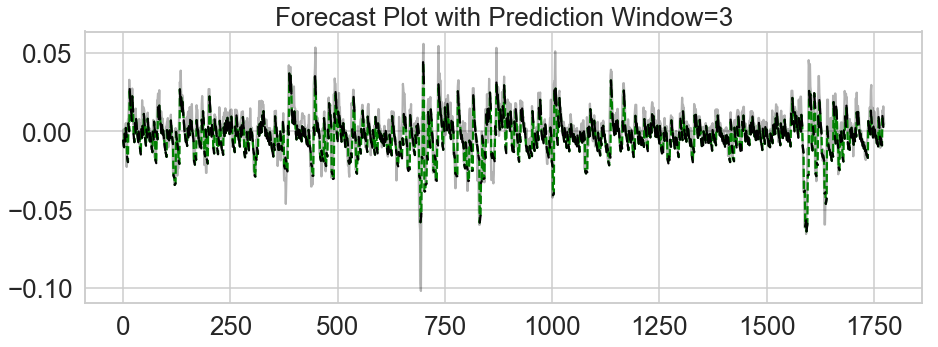

In [10]:
plot_reg_results(test_pred_seqs,y_test,prediction_len=PRED_LENGTH)